In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import models

/home/stepan/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src import display
from src import data_transformer as dt
from src.evaluation import jaccard, non_max_suppression, PredBoundingBox, MAP
from src.augmentations import RandomHorizontalFlip, RandomContrast

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
IMG_PATH = "./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/cocoformatJson/voc_2012_train.json"
val_json_path = "./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/cocoformatJson/voc_2012_val.json"

In [5]:
target_size = 224

seed = 42
device = "cuda"

In [6]:
data_list = []
id_cat, temp_list = dt.load_pascal(train_json_path)
data_list += temp_list
_, temp_list = dt.load_pascal(val_json_path)
data_list += temp_list

random.seed(seed)
random.shuffle(data_list)

In [7]:
data_list = dt.rescale_bounding_boxes(data_list, target_size)
data_list = dt.convert_to_center(data_list)

In [8]:
example = data_list[0]
example

ImageEntry(filename='2009_004619.jpg', width=500, height=333, classnames=['train', 'person', 'person'], class_id=[18, 14, 14], bounding_boxes=[[112.0, 92.5, 224, 185], [80.0, 158.0, 26, 120], [167.0, 83.5, 26, 81]])

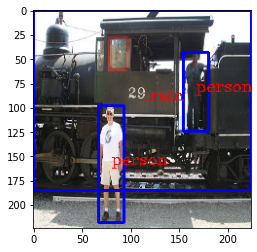

In [9]:
img_str = IMG_PATH + example.filename
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [10]:
anchor_grid = [7, 4, 2, 1] # Number of grid-elements per dimension
anchor_zooms = [0.7, 1.0, 1.3] # How much bigger/smaller each default box will be (percentage)
anchor_ratios = [(1.0, 1.0), (1.0, 0.5), (0.5, 1.0)] # Ratio between (width, height)

anchor_scales = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes = len(anchor_scales)

In [11]:
anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)

anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)

anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

In [12]:
anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)
anchors = torch.from_numpy(anchors).float()
anchors = anchors.to(device)

In [13]:
class PascalData(Dataset):
    def __init__(self, data_list_, target_size_=target_size, path_=IMG_PATH, p=0.5, train_mode=False):
        self.target_size = target_size_
        self.path = path_
        self.data_list = data_list_
        self.p = p

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

        self.train_mode = train_mode
        self.flip = RandomHorizontalFlip(p)
        self.contrast = RandomContrast(p)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        img_str = self.path + item.filename
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0

        gt = np.vstack(item.bounding_boxes)

        if self.train_mode:
            img = self.contrast(img)
            img, gt = self.flip(img, gt)

        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).float().to(device)

        #gt = gt / target_size
        gt = torch.from_numpy(gt).float() / self.target_size
        gt = gt[None, :, :].to(device)

        c = np.array(item.class_id) + 1
        c = torch.from_numpy(np.array(item.class_id)) + 1
        c = c[None, :].to(device)

        return (img, gt, c)

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

In [14]:
batch_size = 128
train_size = 0.9

split_idx = int(train_size * len(data_list))

train_dataset = PascalData(data_list[0:split_idx], train_mode=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

val_dataset = PascalData(data_list[split_idx:])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [15]:
class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, p, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=p)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x        

class OutputConv(nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = nn.Conv2d(in_channels, (len(id_cat) + 1) * self.num_boxes, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels, 4 * self.num_boxes, kernel_size=3, padding=1)

    def flatten_conv(self, x):
        samples, channels, _, _ = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()
        return x.view(samples, -1, int(channels / self.num_boxes))

    def forward(self, x):
        # [class predictions, box coordinates]
        return [self.flatten_conv(self.conv_1(x)), 
                self.flatten_conv(self.conv_2(x))]

class Model(nn.Module):
    def __init__(self, num_boxes, p):
        super().__init__()

        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-2]
        self.backbone = nn.Sequential(*pretrained_model)
        self.backbone_dropout = nn.Dropout2d(p=p[0])

        self.std_conv = nn.ModuleList([
            StandardConv(512, 256, p[1], stride=1),
            StandardConv(256, 256, p[1], stride=1),
            StandardConv(256, 256, p[1]),
            StandardConv(256, 256, p[1]),
            StandardConv(256, 256, p[1])
        ])

        self.out_conv = nn.ModuleList([
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes)
        ])

    def forward(self, x):
        x = self.backbone(x)
        x = self.backbone_dropout(x)

        x = self.std_conv[0](x)
        x = self.std_conv[1](x)
        output_class_0, output_bb_0 = self.out_conv[0](x)

        x = self.std_conv[2](x)
        output_class_1, output_bb_1 = self.out_conv[1](x)

        x = self.std_conv[3](x)
        output_class_2, output_bb_2 = self.out_conv[2](x)

        x = self.std_conv[4](x)
        output_class_3, output_bb_3 = self.out_conv[3](x)

        # Class, bounding box
        return [torch.cat([output_class_0, output_class_1, output_class_2, output_class_3], dim=1),
                torch.cat([output_bb_0, output_bb_1, output_bb_2, output_bb_3], dim=1)
                ]

    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode

    def train(self, mode=True):
        super().train(mode)

        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

In [16]:
def find_overlap(bb_true_i, anchors, jaccard_overlap):
    jaccard_tensor = jaccard(anchors, bb_true_i)
    _, max_overlap = torch.max(jaccard_tensor, dim=0)

    overlap_list = []    
    for i in range(len(bb_true_i)):
        threshold_overlap = (jaccard_tensor[:, i] > jaccard_overlap).nonzero()

        if len(threshold_overlap) > 0:
            threshold_overlap = threshold_overlap[:, 0]
            overlap = torch.cat([max_overlap[i].view(1), threshold_overlap])
            overlap = torch.unique(overlap)     
        else:
            overlap = max_overlap[i].view(1)
        overlap_list.append(overlap)
    return overlap_list

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

In [18]:
class SSDLoss(nn.Module):
    def __init__(self, loc_factor, anchors, jaccard_overlap, **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        self.anchors = anchors

    @staticmethod
    def one_hot_encoding(labels, num_classes):
        return torch.eye(num_classes)[labels]

    @staticmethod
    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true):        
        loc_loss = 0.0
        class_loss = 0.0

        for i in range(len(class_true)):  # Batch level
            class_hat_i = class_hat[i, :, :]
            bb_true_i = bb_true[i]
            class_true_i = class_true[i]
            class_target = torch.zeros(class_hat_i.shape[0]).long().to(device)

            overlap_list = find_overlap(bb_true_i.squeeze(0), self.anchors, self.jaccard_overlap)

            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j]

                input_ = bb_hat[i, overlap, :]
                target_ = SSDLoss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), self.anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = SSDLoss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

In [19]:
loc_factor = 10.0
jaccard_overlap = 0.6

loss = SSDLoss(loc_factor=loc_factor, anchors=anchors, jaccard_overlap=jaccard_overlap)

In [20]:
p = [0.2, 0.5]

torch.manual_seed(seed)
model = Model(num_boxes=num_boxes, p=p).to(device)
model.change_freezing(False)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/stepan/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:07<00:00, 11.2MB/s]


In [21]:
n_epochs = 40
lr = 1e-3
wd = 1e-2

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [22]:
jaccard_threshold = 0.5
map_eval = MAP(model, val_dataset, jaccard_threshold, anchors)

In [26]:
from tqdm import tqdm

In [28]:
torch.manual_seed(seed)
random.seed(seed)
print(len(train_loader))
print(len(val_loader))
for epoch in range(n_epochs+1):
    model.train()

    train_loss, train_loc_loss, train_class_loss  = 0.0, 0.0, 0.0
    for _, (x, bb_true, class_true) in tqdm(enumerate(train_loader)):
        model.zero_grad()
        class_hat, bb_hat = model(x)

        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.detach().cpu().numpy()
        train_class_loss += batch_class.detach().cpu().numpy()
        train_loc_loss += batch_loc.detach().cpu().numpy()

    train_loss =  np.round(train_loss / len(train_loader), 6)
    train_loc_loss =  np.round(train_loc_loss / len(train_loader), 6)
    train_class_loss =  np.round(train_class_loss / len(train_loader), 6)

    val_loss, val_loc_loss, val_class_loss = 0.0, 0.0, 0.0
    for _, (x, bb_true, class_true) in enumerate(val_loader):
        class_hat, bb_hat = model(x)

        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        val_loss += batch_loss.detach().cpu().numpy()
        val_loc_loss += batch_loc.detach().cpu().numpy()
        val_class_loss += batch_class.detach().cpu().numpy()

    val_loss = np.round(val_loss / len(val_loader), 6)
    val_loc_loss = np.round(val_loc_loss / len(val_loader), 6)
    val_class_loss = np.round(val_class_loss / len(val_loader), 6)

    _, mAP = map_eval()
    mAP = np.round(mAP, 6)

    if epoch % 1 == 0:
        print(f"----- Epoch {epoch} -----")
        print(f"Train loss: {train_loss}")
        print(f"Train loc loss: {train_loc_loss}")
        print(f"Train class loss: {train_class_loss}")
        print(f"Val loss: {val_loss}")
        print(f"Val loc loss: {val_loc_loss}")
        print(f"Val class loss: {val_class_loss}")
        print(f"Val mAP: {mAP}")

82
10


82it [04:34,  3.34s/it]


----- Epoch 0 -----
Train loss: 6.09544
Train loc loss: 0.164424
Train class loss: 4.451199
Val loss: 7.050128
Val loc loss: 0.215809
Val class loss: 4.892036
Val mAP: 0.123456


82it [05:09,  3.78s/it]


----- Epoch 1 -----
Train loss: 6.971335
Train loc loss: 0.218152
Train class loss: 4.789818
Val loss: 7.318546
Val loc loss: 0.256379
Val class loss: 4.754753
Val mAP: 0.151704


82it [04:30,  3.30s/it]


----- Epoch 2 -----
Train loss: 6.694966
Train loc loss: 0.211447
Train class loss: 4.580496
Val loss: 6.64139
Val loc loss: 0.210551
Val class loss: 4.535883
Val mAP: 0.160413


82it [04:33,  3.33s/it]


----- Epoch 3 -----
Train loss: 6.475316
Train loc loss: 0.202944
Train class loss: 4.445873
Val loss: 6.805159
Val loc loss: 0.202298
Val class loss: 4.782183
Val mAP: 0.194531


82it [04:25,  3.23s/it]


----- Epoch 4 -----
Train loss: 6.287533
Train loc loss: 0.19665
Train class loss: 4.321035
Val loss: 6.91591
Val loc loss: 0.237507
Val class loss: 4.54084
Val mAP: 0.194905


82it [04:08,  3.03s/it]


----- Epoch 5 -----
Train loss: 6.166698
Train loc loss: 0.193229
Train class loss: 4.234409
Val loss: 6.874124
Val loc loss: 0.238267
Val class loss: 4.491451
Val mAP: 0.219248


82it [04:03,  2.97s/it]


----- Epoch 6 -----
Train loss: 6.026586
Train loc loss: 0.187574
Train class loss: 4.150846
Val loss: 6.301746
Val loc loss: 0.21621
Val class loss: 4.139642
Val mAP: 0.234262


82it [03:28,  2.54s/it]


----- Epoch 7 -----
Train loss: 5.907064
Train loc loss: 0.181649
Train class loss: 4.090571
Val loss: 6.154534
Val loc loss: 0.203154
Val class loss: 4.122993
Val mAP: 0.244119


82it [03:34,  2.61s/it]


----- Epoch 8 -----
Train loss: 5.823544
Train loc loss: 0.180274
Train class loss: 4.0208
Val loss: 5.983541
Val loc loss: 0.18089
Val class loss: 4.174638
Val mAP: 0.256612


82it [03:56,  2.88s/it]


----- Epoch 9 -----
Train loss: 5.705919
Train loc loss: 0.175284
Train class loss: 3.953082
Val loss: 6.355566
Val loc loss: 0.229576
Val class loss: 4.059806
Val mAP: 0.268153


82it [04:00,  2.94s/it]


----- Epoch 10 -----
Train loss: 5.640472
Train loc loss: 0.173581
Train class loss: 3.904658
Val loss: 5.881872
Val loc loss: 0.185934
Val class loss: 4.022535
Val mAP: 0.269142


82it [03:35,  2.63s/it]


----- Epoch 11 -----
Train loss: 5.588817
Train loc loss: 0.172799
Train class loss: 3.860831
Val loss: 6.107404
Val loc loss: 0.196185
Val class loss: 4.145557
Val mAP: 0.289245


82it [03:11,  2.34s/it]


----- Epoch 12 -----
Train loss: 5.520484
Train loc loss: 0.171099
Train class loss: 3.809496
Val loss: 5.887357
Val loc loss: 0.181885
Val class loss: 4.068507
Val mAP: 0.288332


82it [03:09,  2.31s/it]


----- Epoch 13 -----
Train loss: 5.437712
Train loc loss: 0.166571
Train class loss: 3.772005
Val loss: 6.210375
Val loc loss: 0.19773
Val class loss: 4.233078
Val mAP: 0.293902


82it [03:10,  2.32s/it]


----- Epoch 14 -----
Train loss: 5.400309
Train loc loss: 0.166881
Train class loss: 3.731502
Val loss: 5.826342
Val loc loss: 0.197263
Val class loss: 3.85371
Val mAP: 0.304466


82it [03:11,  2.33s/it]


----- Epoch 15 -----
Train loss: 5.301956
Train loc loss: 0.161124
Train class loss: 3.690717
Val loss: 6.885616
Val loc loss: 0.275277
Val class loss: 4.132842
Val mAP: 0.318051


82it [03:11,  2.34s/it]


----- Epoch 16 -----
Train loss: 5.283307
Train loc loss: 0.162447
Train class loss: 3.65884
Val loss: 6.054296
Val loc loss: 0.199089
Val class loss: 4.063408
Val mAP: 0.320465


82it [03:11,  2.33s/it]


----- Epoch 17 -----
Train loss: 5.361652
Train loc loss: 0.172014
Train class loss: 3.641513
Val loss: 5.436559
Val loc loss: 0.177259
Val class loss: 3.663968
Val mAP: 0.323761


82it [03:08,  2.30s/it]


----- Epoch 18 -----
Train loss: 5.2366
Train loc loss: 0.163349
Train class loss: 3.603107
Val loss: 5.687246
Val loc loss: 0.187613
Val class loss: 3.81112
Val mAP: 0.333554


82it [03:09,  2.31s/it]


----- Epoch 19 -----
Train loss: 5.164038
Train loc loss: 0.159571
Train class loss: 3.568324
Val loss: 5.484841
Val loc loss: 0.161679
Val class loss: 3.868053
Val mAP: 0.340852


82it [03:11,  2.33s/it]


----- Epoch 20 -----
Train loss: 5.093248
Train loc loss: 0.155293
Train class loss: 3.54032
Val loss: 6.228248
Val loc loss: 0.231308
Val class loss: 3.915167
Val mAP: 0.361021


82it [03:12,  2.35s/it]


----- Epoch 21 -----
Train loss: 5.063243
Train loc loss: 0.153792
Train class loss: 3.525326
Val loss: 5.546978
Val loc loss: 0.169961
Val class loss: 3.847366
Val mAP: 0.347585


82it [03:11,  2.34s/it]


----- Epoch 22 -----
Train loss: 5.032369
Train loc loss: 0.155081
Train class loss: 3.481558
Val loss: 5.44196
Val loc loss: 0.172067
Val class loss: 3.721293
Val mAP: 0.359189


82it [03:14,  2.37s/it]


----- Epoch 23 -----
Train loss: 4.992784
Train loc loss: 0.152743
Train class loss: 3.46535
Val loss: 5.426544
Val loc loss: 0.172679
Val class loss: 3.699752
Val mAP: 0.347853


82it [03:11,  2.33s/it]


----- Epoch 24 -----
Train loss: 4.959528
Train loc loss: 0.151288
Train class loss: 3.446645
Val loss: 5.576681
Val loc loss: 0.194786
Val class loss: 3.628823
Val mAP: 0.375703


82it [03:12,  2.35s/it]


----- Epoch 25 -----
Train loss: 4.891093
Train loc loss: 0.147462
Train class loss: 3.416478
Val loss: 5.52759
Val loc loss: 0.176463
Val class loss: 3.762958
Val mAP: 0.36189


82it [04:29,  3.29s/it]


----- Epoch 26 -----
Train loss: 4.829031
Train loc loss: 0.143825
Train class loss: 3.390778
Val loss: 5.148826
Val loc loss: 0.1558
Val class loss: 3.590829
Val mAP: 0.381729


82it [04:25,  3.23s/it]


----- Epoch 27 -----
Train loss: 4.807051
Train loc loss: 0.144752
Train class loss: 3.359531
Val loss: 5.03997
Val loc loss: 0.154619
Val class loss: 3.493781
Val mAP: 0.396413


82it [04:11,  3.07s/it]


----- Epoch 28 -----
Train loss: 4.810705
Train loc loss: 0.14516
Train class loss: 3.3591
Val loss: 5.227059
Val loc loss: 0.163546
Val class loss: 3.591599
Val mAP: 0.385765


82it [04:14,  3.10s/it]


----- Epoch 29 -----
Train loss: 4.788105
Train loc loss: 0.143086
Train class loss: 3.35725
Val loss: 5.433829
Val loc loss: 0.184286
Val class loss: 3.590965
Val mAP: 0.397945


82it [04:13,  3.10s/it]


----- Epoch 30 -----
Train loss: 4.770041
Train loc loss: 0.143867
Train class loss: 3.33137
Val loss: 5.349397
Val loc loss: 0.166063
Val class loss: 3.68877
Val mAP: 0.395886


82it [04:11,  3.07s/it]


----- Epoch 31 -----
Train loss: 4.73097
Train loc loss: 0.142589
Train class loss: 3.305081
Val loss: 5.305998
Val loc loss: 0.166198
Val class loss: 3.644014
Val mAP: 0.402577


82it [03:55,  2.87s/it]


----- Epoch 32 -----
Train loss: 4.711226
Train loc loss: 0.142688
Train class loss: 3.284343
Val loss: 5.656758
Val loc loss: 0.181544
Val class loss: 3.841315
Val mAP: 0.405509


82it [03:20,  2.44s/it]


----- Epoch 33 -----
Train loss: 4.702149
Train loc loss: 0.140798
Train class loss: 3.294166
Val loss: 5.255431
Val loc loss: 0.159046
Val class loss: 3.664974
Val mAP: 0.407447


82it [03:18,  2.42s/it]


----- Epoch 34 -----
Train loss: 4.647909
Train loc loss: 0.137835
Train class loss: 3.269562
Val loss: 5.629346
Val loc loss: 0.195956
Val class loss: 3.669784
Val mAP: 0.41572


82it [03:15,  2.39s/it]


----- Epoch 35 -----
Train loss: 4.674797
Train loc loss: 0.140999
Train class loss: 3.264804
Val loss: 5.384977
Val loc loss: 0.170585
Val class loss: 3.67913
Val mAP: 0.407325


82it [03:17,  2.41s/it]


----- Epoch 36 -----
Train loss: 4.616815
Train loc loss: 0.137585
Train class loss: 3.240963
Val loss: 5.143675
Val loc loss: 0.166484
Val class loss: 3.478837
Val mAP: 0.414497


82it [03:17,  2.41s/it]


----- Epoch 37 -----
Train loss: 4.574574
Train loc loss: 0.134926
Train class loss: 3.225311
Val loss: 5.826932
Val loc loss: 0.177505
Val class loss: 4.051885
Val mAP: 0.413473


82it [03:17,  2.41s/it]


----- Epoch 38 -----
Train loss: 4.550571
Train loc loss: 0.133972
Train class loss: 3.210849
Val loss: 5.025001
Val loc loss: 0.153483
Val class loss: 3.490175
Val mAP: 0.409574


82it [03:17,  2.41s/it]


----- Epoch 39 -----
Train loss: 4.52565
Train loc loss: 0.132759
Train class loss: 3.198059
Val loss: 5.270834
Val loc loss: 0.163901
Val class loss: 3.631823
Val mAP: 0.416102


82it [03:10,  2.33s/it]


----- Epoch 40 -----
Train loss: 4.499331
Train loc loss: 0.132235
Train class loss: 3.176983
Val loss: 5.313407
Val loc loss: 0.168943
Val class loss: 3.623977
Val mAP: 0.430005


In [29]:
background_threshold = 0.5

i = 1
(x, bb_true, class_true) = val_dataset[i]
img_file = val_dataset.data_list[i].filename

In [30]:
model.eval()
class_hat, bb_hat = model(x.unsqueeze(0))

bb_hat = dt.invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * target_size

class_hat = class_hat.sigmoid().squeeze(0)

In [31]:
# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]
class_preds = class_hat[:, 1:]

In [32]:
if len(class_preds) > 0:
    prob, class_id = class_preds.max(1)
    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()
else:
    prob = []

In [33]:
output_bb = [PredBoundingBox(probability=prob[j],
                             class_id=class_id[j],
                             classname=id_cat[class_id[j]],
                             bounding_box=[bb_hat[j, 0], 
                                           bb_hat[j, 1], 
                                           bb_hat[j, 2], 
                                           bb_hat[j, 3]])
             for j in range(len(prob))]

output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)

In [34]:
filtered_bb = non_max_suppression(output_bb)

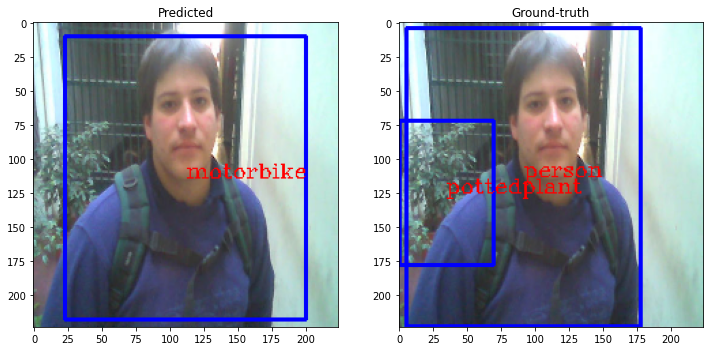

In [35]:
example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file
f, axs = plt.subplots(1, 2, figsize=(12, 12))

img_pred = display.read_img(img_str, target_size)
img_pred = display.draw_boxes(img_pred, [bb.bounding_box for bb in filtered_bb])
img_pred = display.draw_text(img_pred, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = display.read_img(img_str, target_size)
img_gt = display.draw_boxes(img_gt, example.bounding_boxes)
img_gt = display.draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()

In [36]:
torch.save(model, './model.pt')